## estrazione features da reti pretrainate

In [2]:
import numpy as np
import collections
import SimpleITK as sitk
from scipy.ndimage import zoom
import nrrd
import os,sys
import pandas as pd
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import Model
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.applications.resnet50 import ResNet50
import cv2



In [ ]:
### Models
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet', include_top=False)


from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

model = VGG19(weights='imagenet', include_top=False)


from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)


"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-InceptionV3_notop.h5"
"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-ResNet50_notop.h5"
"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-IRV2_notop.h5"

## Singola Slice Imagenet annerita

In [60]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
from keras.preprocessing import image


from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

# Stampa il summary del modello
#model.summary()

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# funzione per creazione maschera
def maskcroppingbox(images_array):
    images_array_2 = np.argwhere(images_array)
    
    (zstart, ystart, xstart), (zstop, ystop, xstop) = images_array_2.min(axis=0), images_array_2.max(axis=0) + 1
    return (zstart, ystart, xstart), (zstop, ystop, xstop)
        
def featureextraction(image_array,mask_array):
    # ridimensionamento
    (zstart, ystart, xstart), (zstop, ystop, xstop) = maskcroppingbox(mask_array)
    roi_images = image_array[zstart-1:zstop+1,ystart:ystop,xstart:xstop].transpose((2,1,0))
    roi_images1 = zoom(roi_images, zoom=[224/roi_images.shape[0], 224/roi_images.shape[1],1], order=3)
    roi_images2 = np.array(roi_images1,dtype=float)    

    # Trova la slice più grossa (basato sui pixel attivi della maschera)
    slice_sums = np.sum(mask_array[zstart-1:zstop+1, ystart:ystop, xstart:xstop], axis=(1, 2))  # Somma dei pixel per slice
    largest_slice_index = np.argmax(slice_sums)  # Indice della slice con il massimo numero di pixel attivi

    # Estrai solo la slice più grossa
    largest_slice_image = roi_images2[:, :, largest_slice_index]

    print(largest_slice_image.shape)

    # preprocessing per resnet
    x = image.img_to_array(largest_slice_image)
    print(x.shape)
    x = np.repeat(x, 3, axis=-1)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    x = preprocess_input(x)

    #x = np.transpose(x, (3, 1, 2, 0))
    
    print(x.shape)

    # estrazione features principali come feature map
    base_model_pool_features = model.predict(x)

    feature_map = base_model_pool_features[0]

    #print(feature_map)

    feature_map = feature_map.transpose((2,1,0))
    
    ## Global Max Pooling
    #features = np.max(feature_map, -1)
    #features = np.max(features, -1)
    
    ## Global Average Pooling
    features = np.mean(feature_map, axis=-1)
    features = np.mean(features, axis=-1)
    
    deeplearningfeatures = collections.OrderedDict()
    for ind_,f_ in enumerate(features):
    	deeplearningfeatures[str(ind_)] = f_
         
    return deeplearningfeatures


# salvataggio features in un file
featureDict = {}
for s in os.listdir(pathdicom):
    print(s)
    filename = os.path.join(pathdicom, s)

        
    for t in os.listdir(filename):

        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):

        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    
    deeplearningfeatures = featureextraction(readdatadicom,readdatanrrd) 

    result = deeplearningfeatures
    key = list(result.keys())
    key = key[0:]
        
    feature = []
    for jind in range(len(key)):
        feature.append(result[key[jind]])
        
    featureDict[s] = feature
    dictkey = key
    print(s)
    
dataframe = pd.DataFrame.from_dict(featureDict, orient='index', columns=dictkey)
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCEPTION_SingolaSlice_Imagenet_Annerita.csv')
    



100
(224, 224)
(224, 224, 1)
(1, 224, 224, 3)
19.235294
(1, 224, 224, 3)


KeyboardInterrupt: 

## Singola Slice Imagenet NON annerita solo ritagliata

100
203
(529, 512, 512)
(224, 224, 1)


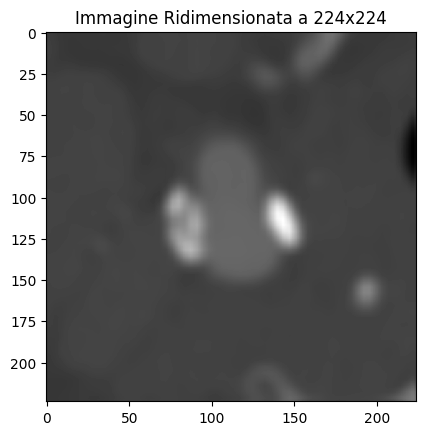

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
100
101
234
(537, 512, 512)
(224, 224, 1)


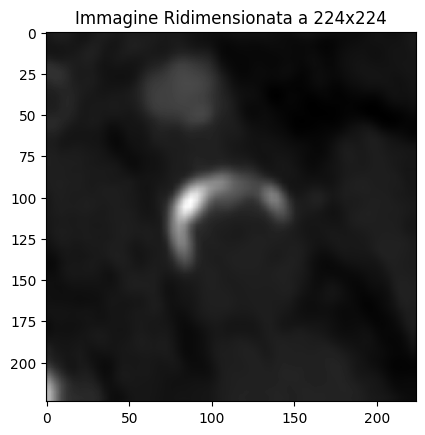

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
101
102
216
(586, 512, 512)
(224, 224, 1)


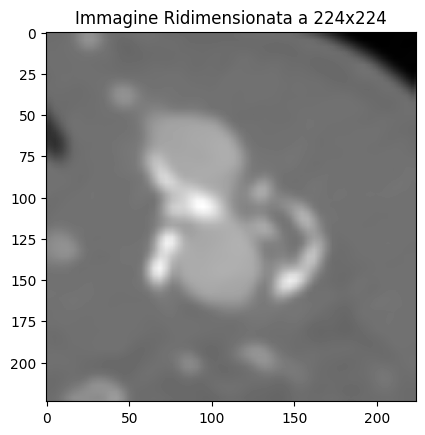

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
102
103
154
(423, 512, 512)
(224, 224, 1)


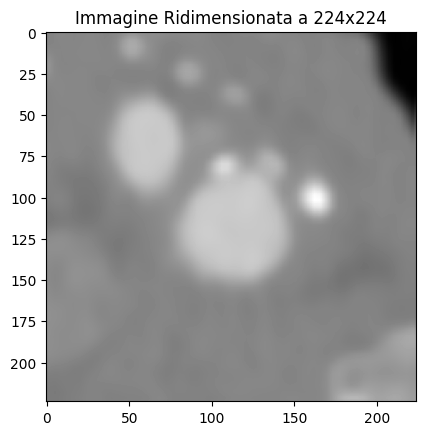

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
103
104
226
(562, 512, 512)
(224, 224, 1)


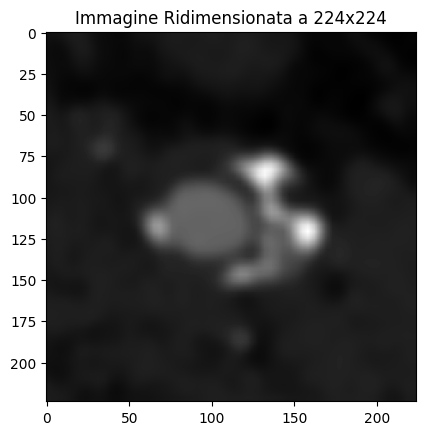

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
104
105
183
(507, 512, 512)
(224, 224, 1)


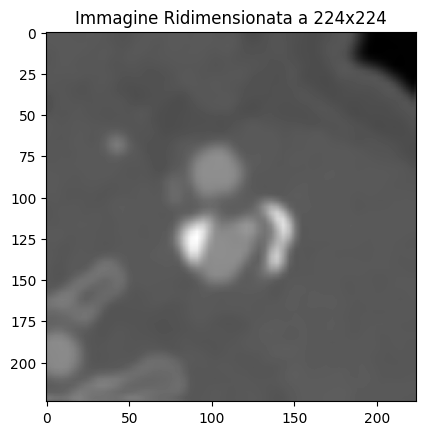

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
105
106


KeyboardInterrupt: 

In [10]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
import matplotlib.pyplot as plt
from keras.preprocessing import image
import cv2

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

# Stampa il summary del modello
#model.summary()

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# funzione per creazione maschera
def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

# Funzione per estrarre le slice con placca
def extract_squares_for_all_slices(image_array, mask_array, target_size=224):
    slices_with_plaque = []

    # Itera attraverso tutte le slice di image_array e mask_array
    for i in range(image_array.shape[0]):
        mask_slice = mask_array[i]
        image_slice = image_array[i]

        # Verifica se la slice ha una placca attiva
        if np.sum(mask_slice) > 0:  # Se la slice contiene la placca
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)

            # Definisci il centro dell'area della placca
            center_y = (ystart + ystop) // 2
            center_x = (xstart + xstop) // 2

            # Definisci il lato del quadrato attorno alla placca
            half_side = min(center_y, center_x, 30)  # Regola per il contesto desiderato
            roi_image = image_slice[
                max(0, center_y-half_side):min(center_y+half_side, image_slice.shape[0]), 
                max(0, center_x-half_side):min(center_x+half_side, image_slice.shape[1])
            ]
            
            # Ridimensiona l'area estratta a 224x224
            roi_image_resized = resize(roi_image, (target_size, target_size), order=1, anti_aliasing=True)

        else:
            roi_image_resized = image_array[i]
            # Aggiungi la slice ridimensionata alla lista
        slices_with_plaque.append(roi_image_resized)

    return slices_with_plaque

# Funzione per estrazione delle feature
def featureextraction(image_array, mask_array):
    roi_images_resized = extract_squares_for_all_slices(image_array, mask_array)

    # Trova la slice più grossa
    slice_sums = np.sum(mask_array, axis=(1, 2))
    largest_slice_index = np.argmax(slice_sums)

    print(largest_slice_index)


    # Estrai solo la slice più grossa
    largest_slice_image = roi_images_resized[largest_slice_index]
    print(image_array.shape)

    #plt.imshow(largest_slice_image, cmap='gray')
    #plt.title("Immagine Ridimensionata a 224x224")
    #plt.show()

    x = image.img_to_array(largest_slice_image)

    print(x.shape)

    # Repeat the channel
    x = np.repeat(x, 3, axis=-1)  

    plt.imshow(x[:,:,0], cmap='gray')
    plt.title("Immagine Ridimensionata a 224x224")
    plt.show()

    
    # Add batch dimension
    x = np.expand_dims(x, axis=0)
    
    print(x.shape)

    x = preprocess_input(x)
    
    #print(np.max(x))

    # Estrazione delle feature principali
    base_model_pool_features = model.predict(x)
    feature_map = base_model_pool_features[0]

    feature_map = feature_map.transpose((2, 1, 0))

    ## Global Max Pooling
    #features = np.max(feature_map, -1)
    #features = np.max(features, -1)
    
    ## Global Average Pooling
    features = np.mean(feature_map, axis=-1)
    features = np.mean(features, axis=-1)

    deeplearningfeatures = collections.OrderedDict()
    for ind_, f_ in enumerate(features):
        deeplearningfeatures[str(ind_)] = f_

    return deeplearningfeatures


# salvataggio features in un file
featureDict = {}
for s in os.listdir(pathdicom):
    print(s)
    filename = os.path.join(pathdicom, s)

        
    for t in os.listdir(filename):

        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):

        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    
    deeplearningfeatures = featureextraction(readdatadicom,readdatanrrd) 

    result = deeplearningfeatures
    key = list(result.keys())
    key = key[0:]
        
    feature = []
    for jind in range(len(key)):
        feature.append(result[key[jind]])
        
    featureDict[s] = feature
    dictkey = key
    print(s)
    
dataframe = pd.DataFrame.from_dict(featureDict, orient='index', columns=dictkey)
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCEPTION_SingolaSlice_Imagenet_Ritagliata.csv')
    



## Singola Slice Imagenet Full Image

100
203
(529, 512, 512)
(512, 512)
Original slice shape: (512, 512)
Input shape for ResNet: (1, 224, 224, 3)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
100
101
234
(537, 512, 512)
(512, 512)
Original slice shape: (512, 512)
Input shape for ResNet: (1, 224, 224, 3)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
101
102
216
(586, 512, 512)
(512, 512)
Original slice shape: (512, 512)
Input shape for ResNet: (1, 224, 224, 3)
(1, 224, 224, 3)
1.0000002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
102
103
154
(423, 512, 512)
(512, 512)
Original slice shape: (512, 512)
Input shape for ResNet: (1, 224, 224, 3)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
103
104
226
(562, 512, 512)
(512, 512)
Original slice shape: (512, 512)
Input shape for ResNet: (1, 224, 224, 3)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
104
105
183
(507, 512, 512)
(512, 512)
Original slice shape: (512, 512)
Input shape for ResNet: (1, 224, 224, 3)
(1, 224, 224, 3)
1.0
1/1 ━━

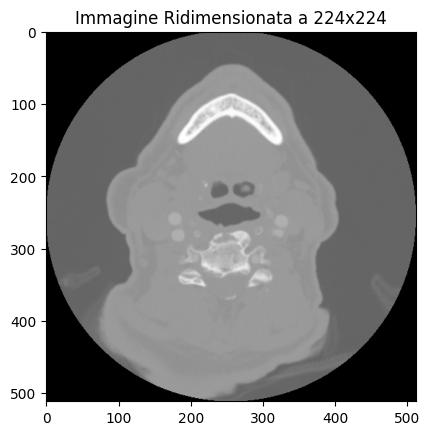

In [4]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
import matplotlib.pyplot as plt
from keras.preprocessing import image
import cv2

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

# Stampa il summary del modello
#model.summary()

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# funzione per creazione maschera
def maskcroppingbox(images_array):
    images_array_2 = np.argwhere(images_array)
    
    (zstart, ystart, xstart), (zstop, ystop, xstop) = images_array_2.min(axis=0), images_array_2.max(axis=0) + 1
    return (zstart, ystart, xstart), (zstop, ystop, xstop)
        

def featureextraction(image_array, mask_array):
    # Trova la slice con l'area più grande
    #(zstart, ystart, xstart), (zstop, ystop, xstop) = maskcroppingbox(mask_array)
    roi_images = image_array  # Nessun ritaglio extra
    mask_slices = mask_array
    
    # Trova la slice più grossa (basato sui pixel attivi della maschera)
    slice_sums = np.sum(mask_slices, axis=(1, 2))  # Somma dei pixel per slice
    largest_slice_index = np.argmax(slice_sums)  # Indice della slice con il massimo numero di pixel attivi

    print(largest_slice_index)
    print(roi_images.shape)

    # Estrai la slice con area maggiore
    largest_slice_image = roi_images[largest_slice_index]

    print(largest_slice_image.shape)

    print(f"Original slice shape: {largest_slice_image.shape}")

    # preprocessing per resnet
    x = image.img_to_array(largest_slice_image)

    plt.imshow(largest_slice_image, cmap='gray')
    plt.title("Immagine Ridimensionata a 224x224")
    #plt.show()
    
    
    x = cv2.resize(x, (224, 224), interpolation=cv2.INTER_LINEAR)
    x = np.repeat(x[..., np.newaxis], 3, axis=-1)  # Aggiungi i 3 canali richiesti da ResNet
    x = np.expand_dims(x, axis=0)  # Aggiungi batch dimension
    print(f"Input shape for ResNet: {x.shape}")

    print(x.shape)

    min_val = np.min(x)
    max_val = np.max(x)
    
    # Normalizza i valori di X tra 0 e 255
    x = 255 * (x - min_val) / (max_val - min_val)

    x = preprocess_input(x)

    print(np.max(x))

    # Estrazione features principali come feature map
    base_model_pool_features = model.predict(x)

    feature_map = base_model_pool_features[0]
    feature_map = feature_map.transpose((2, 1, 0))  # Trasponi feature map
    
    ## Global Max Pooling
    features = np.max(feature_map, -1)
    features = np.max(features, -1)
    
    ## Global Average Pooling
    #features = np.mean(feature_map, axis=-1)
    #features = np.mean(features, axis=-1)


    deeplearningfeatures = collections.OrderedDict()
    
    for ind_, f_ in enumerate(features):
        deeplearningfeatures[str(ind_)] = f_
         
    return deeplearningfeatures


# salvataggio features in un file
featureDict = {}
for s in os.listdir(pathdicom):
    print(s)
    filename = os.path.join(pathdicom, s)

        
    for t in os.listdir(filename):

        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):

        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    
    deeplearningfeatures = featureextraction(readdatadicom,readdatanrrd) 

    result = deeplearningfeatures
    key = list(result.keys())
    key = key[0:]
        
    feature = []
    for jind in range(len(key)):
        feature.append(result[key[jind]])
        
    featureDict[s] = feature
    dictkey = key
    print(s)
    
dataframe = pd.DataFrame.from_dict(featureDict, orient='index', columns=dictkey)
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCEPTION_SingolaSlice_Imagenet_fullimage.csv')
    

print("CSV Creato")

## Multiple Slice

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# funzione per creazione maschera
def maskcroppingbox(images_array):
    images_array_2 = np.argwhere(images_array)
    
    (zstart, ystart, xstart), (zstop, ystop, xstop) = images_array_2.min(axis=0), images_array_2.max(axis=0) + 1
    return (zstart, ystart, xstart), (zstop, ystop, xstop)
        
def featureextraction(image_array, mask_array, patient_id):
    # Ridimensionamento della ROI
    (zstart, ystart, xstart), (zstop, ystop, xstop) = maskcroppingbox(mask_array)
    roi_images = image_array[zstart-1:zstop+1, ystart:ystop, xstart:xstop].transpose((2, 1, 0))
    roi_images1 = zoom(roi_images, zoom=[224/roi_images.shape[0], 224/roi_images.shape[1], 1], order=3)
    roi_images2 = np.array(roi_images1, dtype=float)

    # Prepara tutte le slice come un batch
    batch_slices = []
    for slice_index in range(roi_images2.shape[2]):
        slice_image = roi_images2[:, :, slice_index]
        x = image.img_to_array(slice_image)
        x = np.repeat(x, 3, axis=-1)  # Ripeti il canale se è un'immagine a singolo canale
        batch_slices.append(x)

    # Converti tutte le slice in un batch di input per ResNet
    batch_slices = np.array(batch_slices)
    batch_slices = preprocess_input(batch_slices)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Estrai le feature map per ogni slice e salva con il numero del paziente e della slice
    for slice_index in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[slice_index]

        # Trasposizione e riduzione delle features
        print(feature_map.shape)
        feature_map = feature_map.transpose((2, 1, 0))
        print(feature_map.shape)
        features = np.max(feature_map, -1)
        print(features.shape)
        features = np.max(features, -1)
        print(features.shape)

        # Aggiungi le feature con il numero della slice e del paziente
        feature_entry = {'Patient': patient_id, 'Slice': slice_index}
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(s)
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features per tutte le slice
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\RESNET50_ALL_SLICES_new.csv', index=False)
    



100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)
(2048,)
(7, 7, 2048)
(2048, 7, 7)
(2048, 7)


KeyboardInterrupt: 

## Slice con indici corretti

In [14]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# funzione per creazione maschera
def maskcroppingbox(images_array):
    images_array_2 = np.argwhere(images_array)
    
    (zstart, ystart, xstart), (zstop, ystop, xstop) = images_array_2.min(axis=0), images_array_2.max(axis=0) + 1
    return (zstart, ystart, xstart), (zstop, ystop, xstop)
        
def featureextraction(image_array, mask_array, patient_id):
    # Ridimensionamento della ROI
    (zstart, ystart, xstart), (zstop, ystop, xstop) = maskcroppingbox(mask_array)
    # Qui stiamo lavorando con l'array originale, quindi manteniamo gli indici originali delle slice
    original_slice_indices = np.arange(zstart, zstop)  # Manteniamo gli indici delle slice originali

    # Tagliare il volume solo sulle slice che contengono la placca
    roi_images = image_array[zstart:zstop, ystart:ystop, xstart:xstop].transpose((2, 1, 0))
    roi_images1 = zoom(roi_images, zoom=[224/roi_images.shape[0], 224/roi_images.shape[1], 1], order=3)
    roi_images2 = np.array(roi_images1, dtype=float)

    # Prepara tutte le slice come un batch
    batch_slices = []
    for slice_index in range(roi_images2.shape[2]):
        slice_image = roi_images2[:, :, slice_index]
        x = image.img_to_array(slice_image)
        x = np.repeat(x, 3, axis=-1)  # Ripeti il canale se è un'immagine a singolo canale
        batch_slices.append(x)

    # Converti tutte le slice in un batch di input per ResNet
    batch_slices = np.array(batch_slices)
    batch_slices = preprocess_input(batch_slices)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    placca_indices_3d = list(range(zstart, zstop + 1))


    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        features = np.max(feature_map, -1)
        features = np.max(features, -1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features, placca_indices_3d


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features, placca_indices_3d = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCEPTION_ALL_SLICES_with_3D_indices.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    



Processing patient: 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Processing patient: 101
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
Processing patient: 102
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
Processing patient: 103
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Processing patient: 104
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Processing patient: 105
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
Processing patient: 106
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
Processing patient: 107
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
Processing patient: 108
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
Processing patient: 109
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Processing patient: 110
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
Processing patient: 111
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Processing patient: 112
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
Processing patient: 113
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
Processing patient: 114
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
Processing patient: 115
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/

## 3D

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import nrrd
from torchvision_3d.models import ResNet3D
from torchvision_3d.models import VGG3D
from torchvision_3d.models import DenseNet3D
from scipy.ndimage import zoom

# Carica la ResNet50 3D pretrainata
model = ResNet3D(type='resnet50', pretrained=True)
model = model.eval()  # Modalità inferenza

# Funzione per il cropping della maschera 3D
def maskcroppingbox(images_array):
    images_array_2 = np.argwhere(images_array)
    (zstart, ystart, xstart), (zstop, ystop, xstop) = images_array_2.min(axis=0), images_array_2.max(axis=0) + 1
    return (zstart, ystart, xstart), (zstop, ystop, xstop)

# Funzione per l'estrazione delle feature da un volume 3D
def featureextraction(image_array, mask_array, patient_id):
    # Estrarre solo le slice che contengono la maschera
    (zstart, ystart, xstart), (zstop, ystop, xstop) = maskcroppingbox(mask_array)
    roi_images = image_array[zstart:zstop, ystart:ystop, xstart:xstop]  # Volume 3D
    
    # Ridimensionare il volume alla dimensione richiesta (224x224xD, dove D varia)
    depth = roi_images.shape[0]  # La profondità originale
    print("Original depth:", depth)

    # Ridimensiona altezza e larghezza a 224, mantieni invariata la profondità
    roi_images_resized = zoom(roi_images, zoom=[1, 224/roi_images.shape[1], 224/roi_images.shape[2]], order=3)
    #print("Shape after resize:", roi_images_resized.shape)

    roi_images_resized = np.expand_dims(roi_images_resized, axis=0)  # Aggiungi dimensione batch
    roi_images_resized = np.repeat(roi_images_resized, 3, axis=0)  # Da (1, D, H, W) a (3, D, H, W)

    # Converti il volume 3D in tensor
    volume_tensor = torch.tensor(roi_images_resized, dtype=torch.float32)
    volume_tensor = volume_tensor.unsqueeze(0)  # (1, 1, D, H, W) - batch size 1, canale 1

    #print(volume_tensor.shape)

    # Passa il volume 3D attraverso la rete pre-addestrata
    with torch.no_grad():
        features = model(volume_tensor)

    #print(f"Features shape: {features.shape}")
    # Estrai le feature map finali (saranno 2048 features per ResNet50)
    features = features.squeeze().numpy()
    print(f"Features shape: {features.shape}")
    features = np.max(features, axis=3)  # Riduci lungo la profondità
    features = np.max(features, axis=2)  # Riduci lungo una dimensione spaziale
    features = np.max(features, axis=1)  # Riduci lungo l'altra dimensione spaziale
    #print(f"Features shape: {features.shape}")

    # Aggiungi le feature con il numero del paziente e la profondità
    feature_entry = {'Patient': patient_id}
    for ind_, f_ in enumerate(features):
        feature_entry[f'Feature_{ind_}'] = f_

    return feature_entry

# Percorsi ai dati
pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# Inizializza lista per salvare tutte le feature
all_feature_dicts = []

# Ciclo sui pazienti
for s in os.listdir(pathdicom):
    print(s)
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features per il volume 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.append(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\RESNET50_3D.csv', index=False)



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

__all__ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]


def conv3x3x3(in_planes, out_planes, stride=1, dilation=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        dilation=dilation,
        stride=stride,
        padding=dilation,
        bias=False)


def downsample_basic_block(x, planes, stride, no_cuda=False):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if not no_cuda:
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes, dilation=dilation)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_input_D,
                 sample_input_H,
                 sample_input_W,
                 num_seg_classes,
                 remove_fc=False,
                 shortcut_type='B',
                 no_cuda = False):
        self.inplanes = 64
        self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            1,
            64,
            kernel_size=7,
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            bias=False)
            
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=1, dilation=4)

        if not remove_fc:
            self.conv_seg = nn.Sequential(
                                            nn.ConvTranspose3d(
                                            512 * block.expansion,
                                            32,
                                            2,
                                            stride=2
                                            ),
                                            nn.BatchNorm3d(32),
                                            nn.ReLU(inplace=True),
                                            nn.Conv3d(
                                            32,
                                            32,
                                            kernel_size=3,
                                            stride=(1, 1, 1),
                                            padding=(1, 1, 1),
                                            bias=False), 
                                            nn.BatchNorm3d(32),
                                            nn.ReLU(inplace=True),
                                            nn.Conv3d(
                                            32,
                                            num_seg_classes,
                                            kernel_size=1,
                                            stride=(1, 1, 1),
                                            bias=False) 
                                            )
        else:
            self.conv_seg = None 

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride,
                    no_cuda=self.no_cuda)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.conv_seg is not None:
            x = self.conv_seg(x)

        return x

def resnet10(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [10]:
model = resnet50(
    sample_input_D=64,   # Valore temporaneo per D, può essere variabile
    sample_input_H=224,  # Altezza dell'input
    sample_input_W=224,  # Larghezza dell'input
    num_seg_classes=2,   # Numero di classi di segmentazione
    remove_fc=True       # Rimuove lo strato finale
)

# Carica i pesi dal file .pth
checkpoint = torch.load(r"C:\Users\bsbar\Desktop\resnet_50.pth", map_location=torch.device('cpu'))

# Rimuovi il prefisso 'module.' se necessario
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k.replace("module.", "")  # Rimuovi 'module.' se necessario
    new_state_dict[name] = v

# Carica lo state_dict nel modello
model.load_state_dict(new_state_dict)

# Imposta il modello in modalità inferenza
model.eval()

C:\Users\bsbar\AppData\Local\Temp\ipykernel_24896\1896242771.py:177: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(64

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import nrrd
from torchvision_3d.models import ResNet3D
from torchvision_3d.models import VGG3D
from torchvision_3d.models import DenseNet3D
from scipy.ndimage import zoom

# Carica la ResNet50 3D pretrainata
model = resnet50(
    sample_input_D=64,   # Valore temporaneo per D, può essere variabile
    sample_input_H=224,  # Altezza dell'input
    sample_input_W=224,  # Larghezza dell'input
    num_seg_classes=2,   # Numero di classi di segmentazione
    remove_fc=True       # Rimuove lo strato finale
)

# Carica i pesi dal file .pth
checkpoint = torch.load(r"C:\Users\bsbar\Desktop\resnet_50.pth", map_location=torch.device('cpu'))

# Rimuovi il prefisso 'module.' se necessario
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k.replace("module.", "")  # Rimuovi 'module.' se necessario
    new_state_dict[name] = v

# Carica lo state_dict nel modello
model.load_state_dict(new_state_dict)

# Imposta il modello in modalità inferenza
model.eval()

# Funzione per il cropping della maschera 3D
def maskcroppingbox(images_array):
    images_array_2 = np.argwhere(images_array)
    (zstart, ystart, xstart), (zstop, ystop, xstop) = images_array_2.min(axis=0), images_array_2.max(axis=0) + 1
    return (zstart, ystart, xstart), (zstop, ystop, xstop)

# Funzione per l'estrazione delle feature da un volume 3D
def featureextraction(image_array, mask_array, patient_id):
    # Estrarre solo le slice che contengono la maschera
    (zstart, ystart, xstart), (zstop, ystop, xstop) = maskcroppingbox(mask_array)
    roi_images = image_array[zstart:zstop, ystart:ystop, xstart:xstop]  # Volume 3D
    
    # Ridimensionare il volume alla dimensione richiesta (224x224xD, dove D varia)
    depth = roi_images.shape[0]  # La profondità originale
    print("Original depth:", depth)

    # Ridimensiona altezza e larghezza a 224, mantieni invariata la profondità
    roi_images_resized = zoom(roi_images, zoom=[1, 224/roi_images.shape[1], 224/roi_images.shape[2]], order=3)
    #print("Shape after resize:", roi_images_resized.shape)

    roi_images_resized = np.expand_dims(roi_images_resized, axis=0)  # Aggiungi dimensione batch
    #roi_images_resized = np.repeat(roi_images_resized, 3, axis=0)  # Da (1, D, H, W) a (3, D, H, W)

    # Converti il volume 3D in tensor
    volume_tensor = torch.tensor(roi_images_resized, dtype=torch.float32)
    volume_tensor = volume_tensor.unsqueeze(0)  # (1, 1, D, H, W) - batch size 1, canale 1

    print(volume_tensor.shape)

    # Passa il volume 3D attraverso la rete pre-addestrata
    with torch.no_grad():
        features = model(volume_tensor)

    #print(f"Features shape: {features.shape}")
    # Estrai le feature map finali (saranno 2048 features per ResNet50)
    features = features.squeeze().numpy()
    print(f"Features shape: {features.shape}")
    features = np.max(features, axis=3)  # Riduci lungo la profondità
    features = np.max(features, axis=2)  # Riduci lungo una dimensione spaziale
    features = np.max(features, axis=1)  # Riduci lungo l'altra dimensione spaziale
    #print(f"Features shape: {features.shape}")

    # Aggiungi le feature con il numero del paziente e la profondità
    feature_entry = {'Patient': patient_id}
    for ind_, f_ in enumerate(features):
        feature_entry[f'Feature_{ind_}'] = f_

    return feature_entry

# Percorsi ai dati
pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

# Inizializza lista per salvare tutte le feature
all_feature_dicts = []

# Ciclo sui pazienti
for s in os.listdir(pathdicom):
    print(s)
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features per il volume 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.append(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\RESNET50_3D.csv', index=False)



C:\Users\bsbar\AppData\Local\Temp\ipykernel_24896\1896242771.py:177: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


100
Original depth: 38
torch.Size([1, 1, 38, 224, 224])
Features shape: (2048, 5, 28, 28)
101
Original depth: 42
torch.Size([1, 1, 42, 224, 224])
Features shape: (2048, 6, 28, 28)
102
Original depth: 54
torch.Size([1, 1, 54, 224, 224])
Features shape: (2048, 7, 28, 28)
103
Original depth: 46
torch.Size([1, 1, 46, 224, 224])
Features shape: (2048, 6, 28, 28)
104
Original depth: 45
torch.Size([1, 1, 45, 224, 224])
Features shape: (2048, 6, 28, 28)
105
Original depth: 38
torch.Size([1, 1, 38, 224, 224])
Features shape: (2048, 5, 28, 28)
106
Original depth: 30
torch.Size([1, 1, 30, 224, 224])
Features shape: (2048, 4, 28, 28)
107
Original depth: 44
torch.Size([1, 1, 44, 224, 224])
Features shape: (2048, 6, 28, 28)
108
Original depth: 27
torch.Size([1, 1, 27, 224, 224])
Features shape: (2048, 4, 28, 28)
109
Original depth: 41
torch.Size([1, 1, 41, 224, 224])
Features shape: (2048, 6, 28, 28)
110
Original depth: 49
torch.Size([1, 1, 49, 224, 224])
Features shape: (2048, 7, 28, 28)
111
Origin

## Rete con pesi diversi immagini full

In [15]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.applications.resnet50 import ResNet50
import cv2


from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input

#model =ResNet50(weights='imagenet', include_top=False)


#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-InceptionV3_notop.h5"
#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-ResNet50_notop.h5"
#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-IRV2_notop.h5"

# Carica il modello pre-addestrato RadImageNet ResNet50
model_path = r"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-InceptionV3_notop.h5"
model = load_model(model_path)

#model = ResNet50(weights='imagenet', include_top=False)
# Stampa il summary del modello
#model.summary()

# Funzione per creazione maschera
def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

# Funzione per estrarre le slice con placca
def extract_squares_for_all_slices(image_array, mask_array, target_size=224):
    slices_with_plaque = []

    # Itera attraverso tutte le slice di image_array e mask_array
    for i in range(image_array.shape[0]):
        mask_slice = mask_array[i]
        image_slice = image_array[i]

        # Verifica se la slice ha una placca attiva
        if np.sum(mask_slice) > 0:  # Se la slice contiene la placca
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)

            # Definisci il centro dell'area della placca
            center_y = (ystart + ystop) // 2
            center_x = (xstart + xstop) // 2

            # Definisci il lato del quadrato attorno alla placca
            half_side = min(center_y, center_x, 30)  # Regola per il contesto desiderato

            #print(np.max(image_slice))    
            image_slice_normalized = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice)) 
            #print(np.max(image_slice_normalized))     
            # Estrai un'area quadrata attorno alla placca
            roi_image = image_slice_normalized[
                max(0, center_y-half_side):min(center_y+half_side, image_slice.shape[0]), 
                max(0, center_x-half_side):min(center_x+half_side, image_slice.shape[1])
            ]
            
            # Ridimensiona l'area estratta a 224x224
            roi_image_resized = resize(roi_image, (target_size, target_size), order=1, anti_aliasing=True)

        else:
            roi_image_resized = image_array[i]
            # Aggiungi la slice ridimensionata alla lista
        slices_with_plaque.append(roi_image_resized)

    return slices_with_plaque

# Funzione per estrazione delle feature
def featureextraction(image_array, mask_array):
    #roi_images_resized = extract_squares_for_all_slices(image_array, mask_array)
    #print(roi_images_resized.shape)
    # Trova la slice più grossa
    slice_sums = np.sum(mask_array, axis=(1, 2))
    largest_slice_index = np.argmax(slice_sums)

    #print(largest_slice_index)


    # Estrai solo la slice più grossa
    #largest_slice_image = roi_images_resized[largest_slice_index]
    print(image_array.shape)

    largest_slice_image = image_array[largest_slice_index]




    #plt.imshow(largest_slice_image, cmap='gray')
    #plt.title("Immagine Ridimensionata a 224x224")
    #plt.show()

    x = image.img_to_array(largest_slice_image)

    print(x.shape)

    min_val = np.min(x)
    max_val = np.max(x)

# Normalizza i valori tra 0 e 1 usando min-max normalization
    x = (x - min_val) / (max_val - min_val)

    # Resize to 224*224
    x = cv2.resize(x, (224, 224))

    # Add channel dimension
    x = np.expand_dims(x, axis=-1)

    # Repeat the channel
    x = np.repeat(x, 3, axis=-1)    
    
    # Add batch dimension
    x = np.expand_dims(x, axis=0)
    
    print(x.shape)
    print(np.max(x))

    # Preprocessamento e estrazione delle feature (da adattare alla tua rete)
    #x = np.expand_dims(largest_slice_image, axis=0)
    #x = preprocess_input(x)

    #print(x.shape)


    # Estrazione delle feature principali
    base_model_pool_features = model.predict(x)
    feature_map = base_model_pool_features[0]

    feature_map = feature_map.transpose((2, 1, 0))
    ## Global Max Pooling
    #features = np.max(feature_map, -1)
    #features = np.max(features, -1)
    
    ## Global Average Pooling
    features = np.mean(feature_map, axis=-1)
    features = np.mean(features, axis=-1)
    
    deeplearningfeatures = collections.OrderedDict()
    for ind_, f_ in enumerate(features):
        deeplearningfeatures[str(ind_)] = f_

    return deeplearningfeatures


# Salvataggio delle feature in un file CSV
pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

featureDict = {}
for s in os.listdir(pathdicom):
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    deeplearningfeatures = featureextraction(readdatadicom, readdatanrrd)

    result = deeplearningfeatures
    key = list(result.keys())

    feature = []
    for jind in range(len(key)):
        feature.append(result[key[jind]])

    featureDict[s] = feature
    dictkey = key
    print(s)

dataframe = pd.DataFrame.from_dict(featureDict, orient='index', columns=dictkey)
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCEPTION_SliceMaggiore_NuoviPesi_fullimage_GAP.csv')


(529, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
0.9766924
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
100
(537, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
101
(586, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
0.9844302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
102
(423, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
103
(562, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
0.9614725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
104
(507, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
105
(600, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
0.99883276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
106
(536, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
0.97040004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
107
(488, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
108
(542, 512, 512)
(512, 512, 1)
(1, 224, 224, 3)
0.9904713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
109
(535, 512, 512)
(512, 512, 1)
(1, 

## Encoder pesi personalizzati slice solo ritagliata

In [6]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.applications.resnet50 import ResNet50
import cv2


from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input

#model =ResNet50(weights='imagenet', include_top=False)

#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-InceptionV3_notop.h5"
#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-ResNet50_notop.h5"
#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-IRV2_notop.h5"

# Carica il modello pre-addestrato RadImageNet ResNet50
model_path = r"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-ResNet50_notop.h5"
model = load_model(model_path)

#model = ResNet50(weights='imagenet', include_top=False)
# Stampa il summary del modello
#model.summary()

# Funzione per creazione maschera
def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

# Funzione per estrarre le slice con placca
def extract_squares_for_all_slices(image_array, mask_array, target_size=224):
    slices_with_plaque = []

    # Itera attraverso tutte le slice di image_array e mask_array
    for i in range(image_array.shape[0]):
        mask_slice = mask_array[i]
        image_slice = image_array[i]

        # Verifica se la slice ha una placca attiva
        if np.sum(mask_slice) > 0:  # Se la slice contiene la placca
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)

            # Definisci il centro dell'area della placca
            center_y = (ystart + ystop) // 2
            center_x = (xstart + xstop) // 2

            # Definisci il lato del quadrato attorno alla placca
            half_side = min(center_y, center_x, 30)  # Regola per il contesto desiderato

            #print(np.max(image_slice))    
            image_slice_normalized = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice)) 
            #print(np.max(image_slice_normalized))     
            # Estrai un'area quadrata attorno alla placca
            roi_image = image_slice_normalized[
                max(0, center_y-half_side):min(center_y+half_side, image_slice.shape[0]), 
                max(0, center_x-half_side):min(center_x+half_side, image_slice.shape[1])
            ]
            
            # Ridimensiona l'area estratta a 224x224
            roi_image_resized = resize(roi_image, (target_size, target_size), order=1, anti_aliasing=True)

        else:
            roi_image_resized = image_array[i]
            # Aggiungi la slice ridimensionata alla lista
        slices_with_plaque.append(roi_image_resized)

    return slices_with_plaque

# Funzione per estrazione delle feature
def featureextraction(image_array, mask_array):
    roi_images_resized = extract_squares_for_all_slices(image_array, mask_array)

    # Trova la slice più grossa
    slice_sums = np.sum(mask_array, axis=(1, 2))
    largest_slice_index = np.argmax(slice_sums)

    print(largest_slice_index)


    # Estrai solo la slice più grossa
    largest_slice_image = roi_images_resized[largest_slice_index]
    print(image_array.shape)

    #plt.imshow(largest_slice_image, cmap='gray')
    #plt.title("Immagine Ridimensionata a 224x224")
    #plt.show()

    x = image.img_to_array(largest_slice_image)

    print(x.shape)

    # Repeat the channel
    x = np.repeat(x, 3, axis=-1)    
    
    # Add batch dimension
    x = np.expand_dims(x, axis=0)
    
    print(x.shape)
    
    print(np.max(x))

    # Estrazione delle feature principali
    base_model_pool_features = model.predict(x)
    feature_map = base_model_pool_features[0]

    feature_map = feature_map.transpose((2, 1, 0))

    ## Global Max Pooling
    features = np.max(feature_map, -1)
    features = np.max(features, -1)
    
    ## Global Average Pooling
    #features = np.mean(feature_map, axis=-1)
    #features = np.mean(features, axis=-1)

    deeplearningfeatures = collections.OrderedDict()
    for ind_, f_ in enumerate(features):
        deeplearningfeatures[str(ind_)] = f_

    return deeplearningfeatures


# Salvataggio delle feature in un file CSV
pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

featureDict = {}
for s in os.listdir(pathdicom):
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    deeplearningfeatures = featureextraction(readdatadicom, readdatanrrd)

    result = deeplearningfeatures
    key = list(result.keys())

    feature = []
    for jind in range(len(key)):
        feature.append(result[key[jind]])

    featureDict[s] = feature
    dictkey = key
    print(s)

dataframe = pd.DataFrame.from_dict(featureDict, orient='index', columns=dictkey)
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\RESNET_SliceMaggiore_NuoviPesi_Ritagliata.csv')


203
(529, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
100
234
(537, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
101
216
(586, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
102
154
(423, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
103
226
(562, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
104
183
(507, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
105
267
(600, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
106
207
(536, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
107
209
(488, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
108
229
(542, 512, 512)
(224, 224, 1)
(1, 224, 224, 3)
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
109
184
(535, 512, 512)
(224, 224

## Pesi personalizzati e immagini annerite

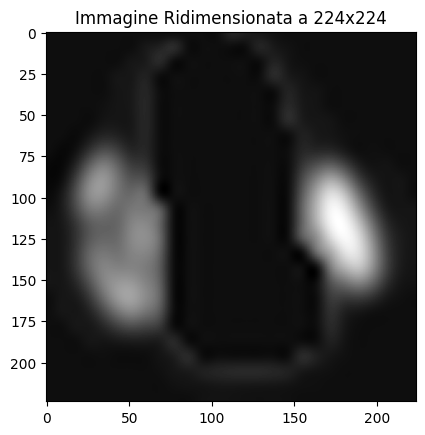

(1, 224, 224, 3)
1.0


KeyboardInterrupt: 

In [15]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd
import nrrd
from scipy.ndimage import zoom
import collections
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.applications.resnet50 import ResNet50
import cv2


from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input

#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-InceptionV3_notop.h5"
#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-ResNet50_notop.h5"
#"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-IRV2_notop.h5"

# Carica il modello pre-addestrato RadImageNet ResNet50
model_path = r"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-IRV2_notop.h5"
model = load_model(model_path)

#model = ResNet50(weights='imagenet', include_top=False)
# Stampa il summary del modello
#model.summary()

# Funzione per creazione maschera
def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def extract_squares_for_all_slices(image_array, mask_array, target_size=224):
    slices_with_plaque = []

    # Itera attraverso tutte le slice di image_array e mask_array
    for i in range(image_array.shape[0]):
        mask_slice = mask_array[i]
        image_slice = image_array[i]

        # Verifica se la slice ha una placca attiva
        if np.sum(mask_slice) > 0:  # Se la slice contiene la placca
            # Trova i limiti della ROI della placca
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)

            # Annerisci le zone esterne alla placca
            masked_image = np.where(mask_slice > 0, image_slice, 0)  # Mantiene i pixel solo dove la maschera è > 0

            # Estrai la regione di interesse (ROI) dalla slice e applica lo zoom
            roi_image = masked_image[ystart:ystop, xstart:xstop]

            # Applica lo zoom per ridimensionare a 224x224
            zoom_factors = [224 / roi_image.shape[0], 224 / roi_image.shape[1]]
            roi_image_zoomed = zoom(roi_image, zoom=zoom_factors, order=3)

            # Converti il risultato in float
            roi_image_resized = np.array(roi_image_zoomed, dtype=float)
        else:
            # Se la slice non contiene placca, la slice viene riempita di zeri
            roi_image_resized = np.zeros((target_size, target_size))

        # Aggiungi la slice ridimensionata alla lista
        slices_with_plaque.append(roi_image_resized)

    return slices_with_plaque

# Modifica della funzione featureextraction per mantenere il flusso
def featureextraction(image_array, mask_array):
    roi_images_resized = extract_squares_for_all_slices(image_array, mask_array)

    # Trova la slice con la placca più grande
    slice_sums = np.sum(mask_array, axis=(1, 2))
    largest_slice_index = np.argmax(slice_sums)

    # Estrai solo la slice più grande
    largest_slice_image = roi_images_resized[largest_slice_index]

    plt.imshow(largest_slice_image, cmap='gray')
    plt.title("Immagine Ridimensionata a 224x224")
    plt.show()

    x = image.img_to_array(largest_slice_image)

    min_val = np.min(x)
    max_val = np.max(x)

    # Normalizza i valori tra 0 e 1 
    x = (x - min_val) / (max_val - min_val)

    # Repeat the channel to 3
    x = np.repeat(x, 3, axis=-1)

    # Add batch dimension
    x = np.expand_dims(x, axis=0)

    print(x.shape)

    print(np.max(x))

    # Estrazione delle feature principali
    base_model_pool_features = model.predict(x)
    feature_map = base_model_pool_features[0]

    # Prende il massimo della feature map
    feature_map = feature_map.transpose((2, 1, 0))
    
    ## Global Max Pooling
    #features = np.max(feature_map, -1)
    #features = np.max(features, -1)
    
    ## Global Average Pooling
    features = np.mean(feature_map, axis=-1)
    features = np.mean(features, axis=-1)
    
    deeplearningfeatures = collections.OrderedDict()
    for ind_, f_ in enumerate(features):
        deeplearningfeatures[str(ind_)] = f_

    return deeplearningfeatures


# Salvataggio delle feature in un file CSV
pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"

featureDict = {}
for s in os.listdir(pathdicom):
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    deeplearningfeatures = featureextraction(readdatadicom, readdatanrrd)

    result = deeplearningfeatures
    key = list(result.keys())

    feature = []
    for jind in range(len(key)):
        feature.append(result[key[jind]])

    featureDict[s] = feature
    dictkey = key
    print(s)

dataframe = pd.DataFrame.from_dict(featureDict, orient='index', columns=dictkey)
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCRES_SliceMaggiore_NuoviPesi_annerita.csv')


# MULTIPLE SLICE


### Imagenet Annerita

Processing patient: 100


Indici iniziali e finali:  191 228


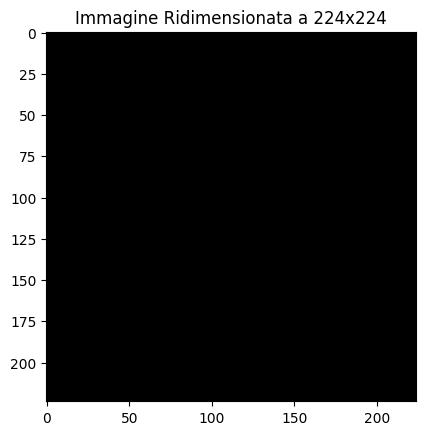

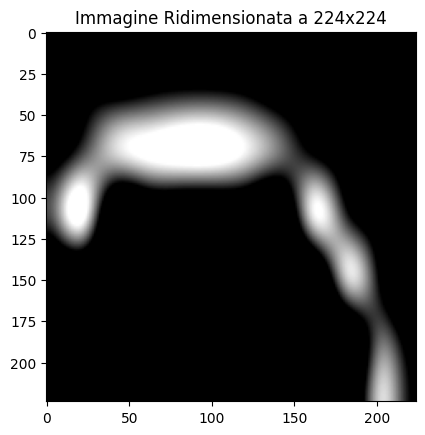

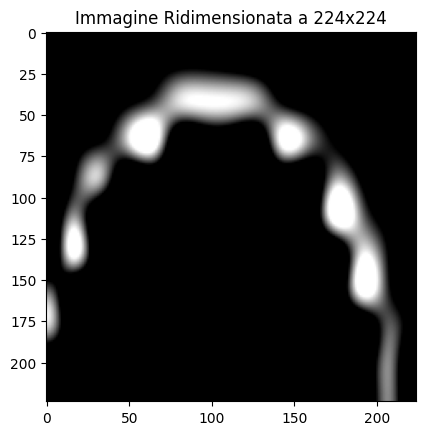

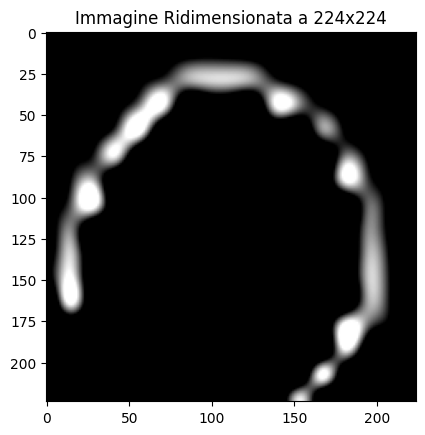

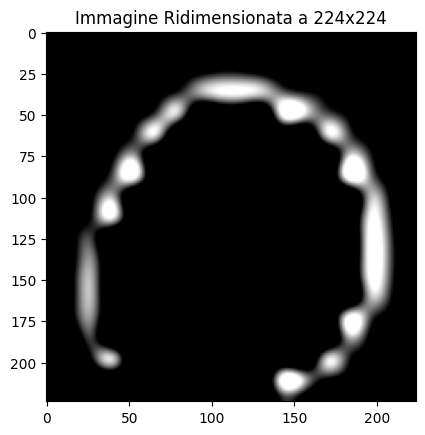

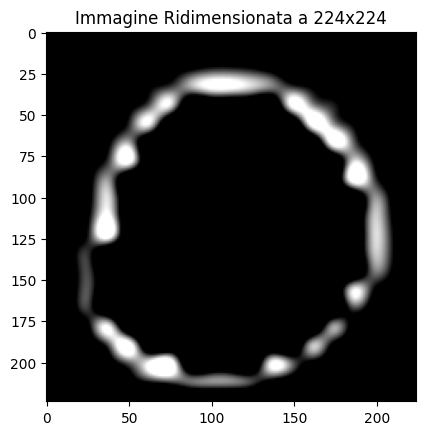

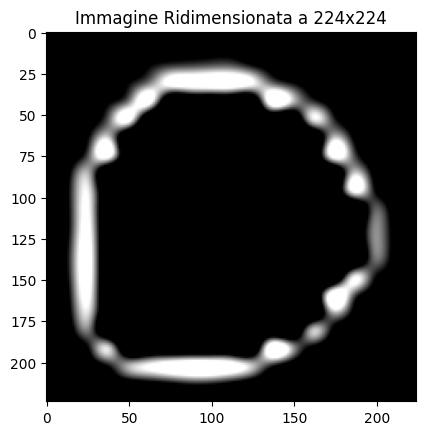

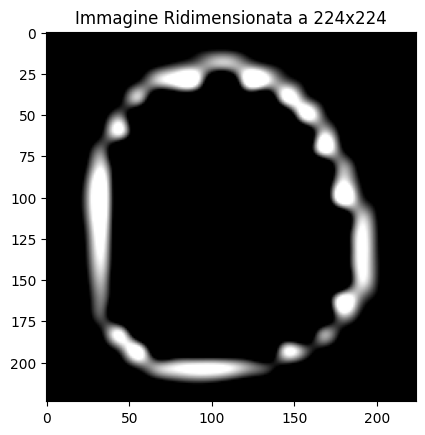

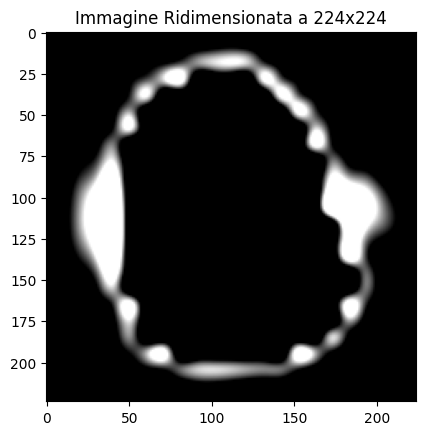

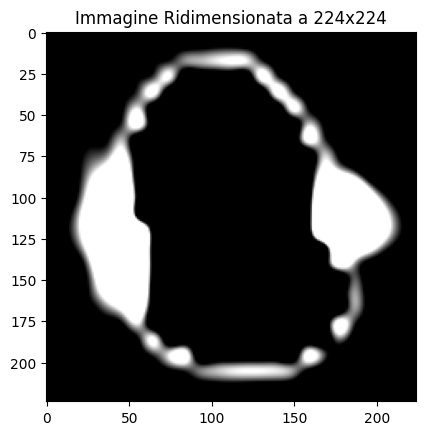

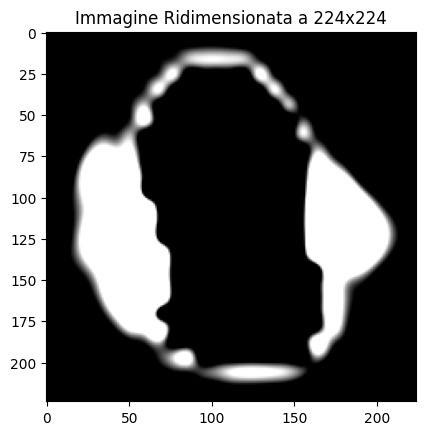

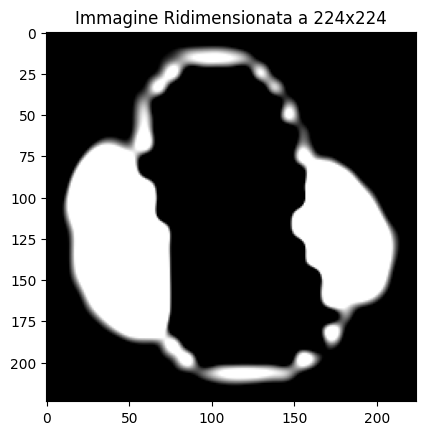

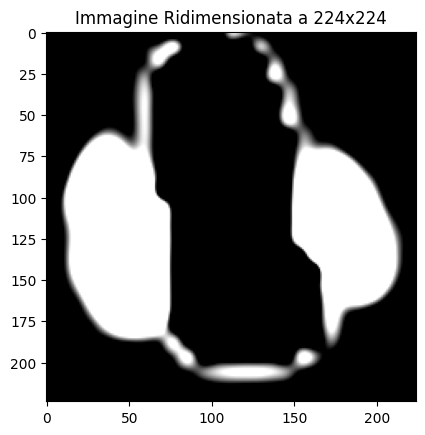

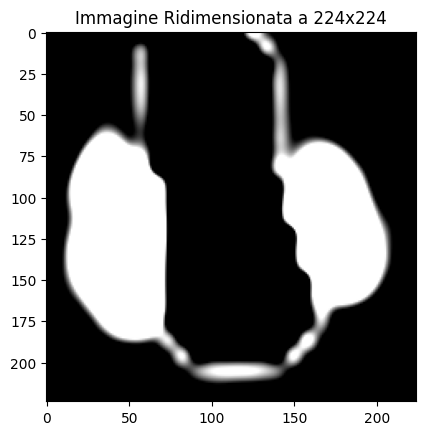

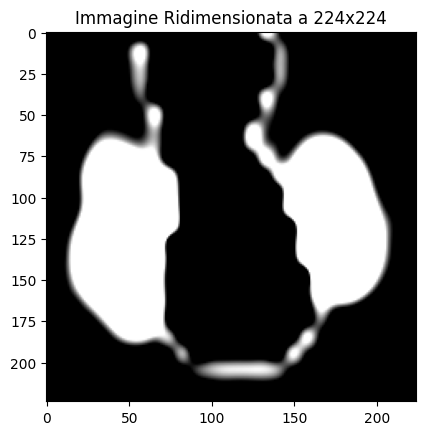

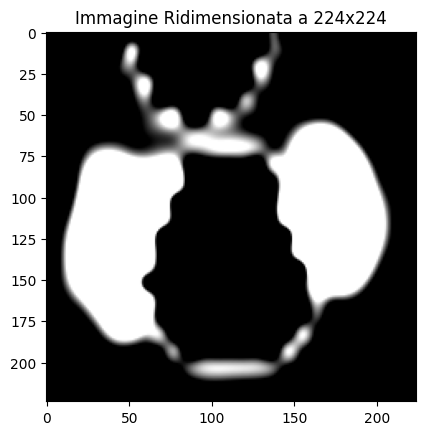

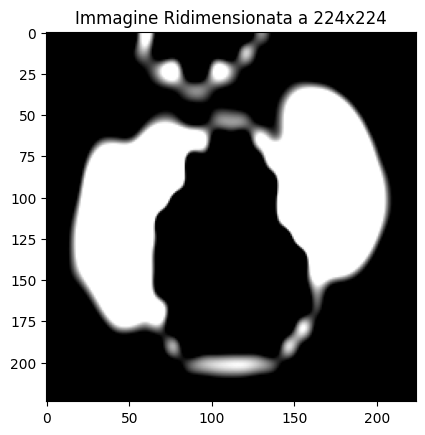

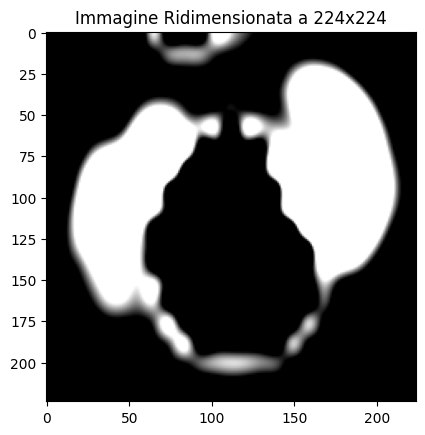

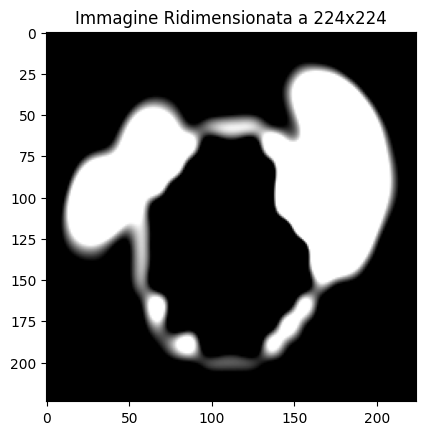

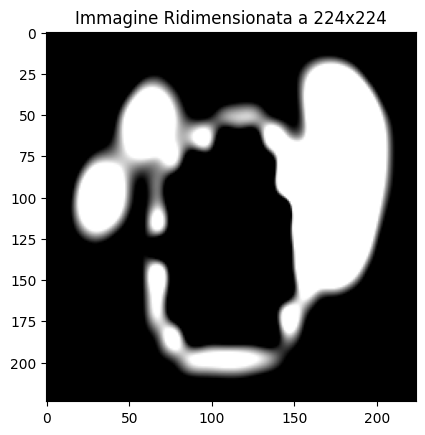

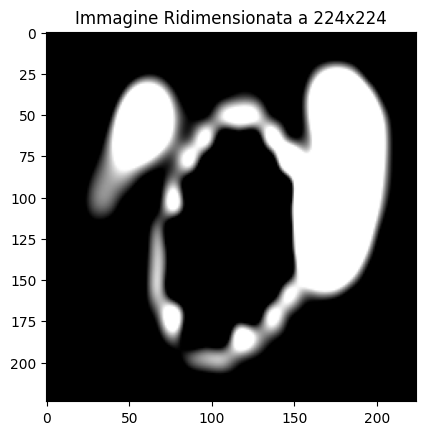

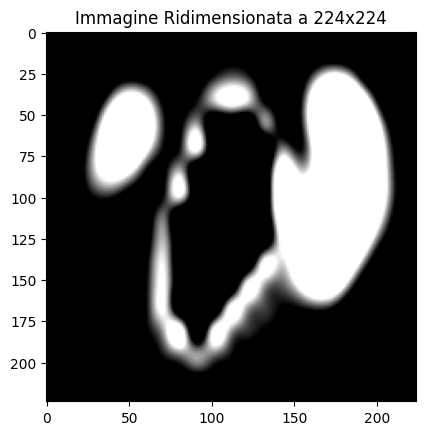

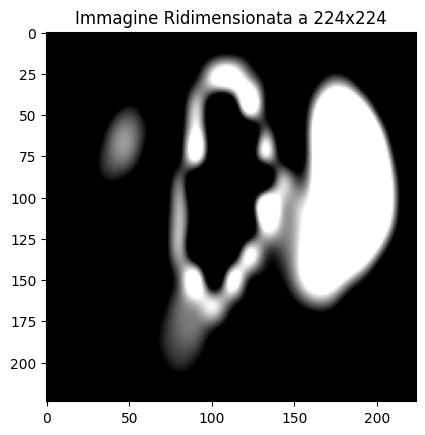

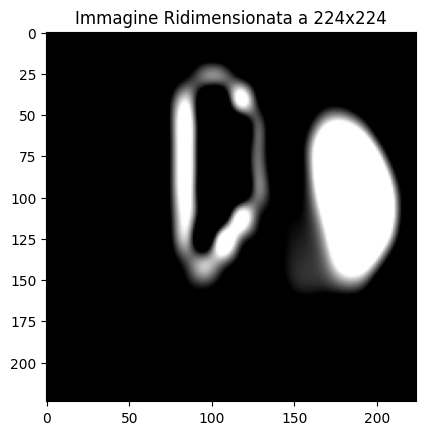

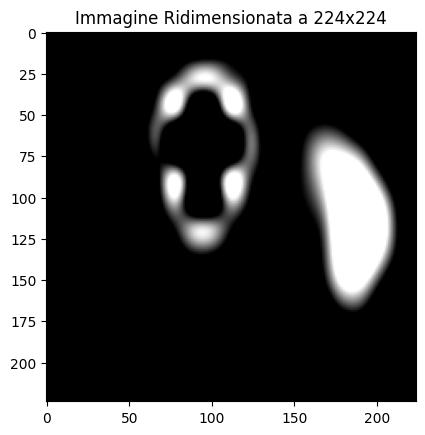

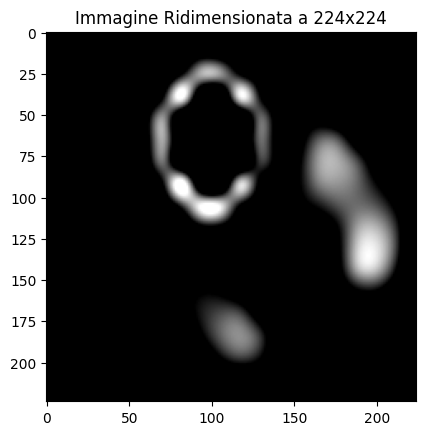

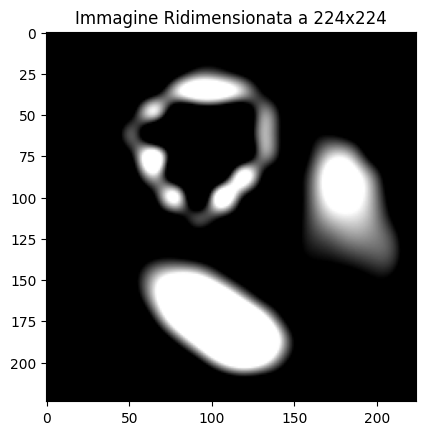

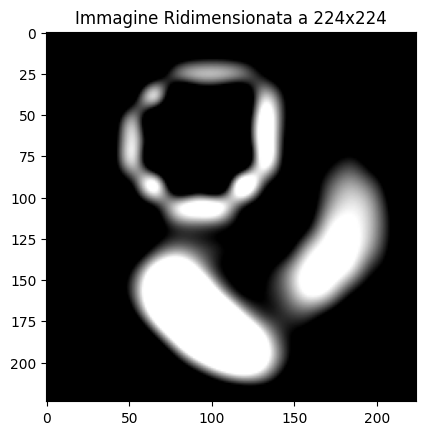

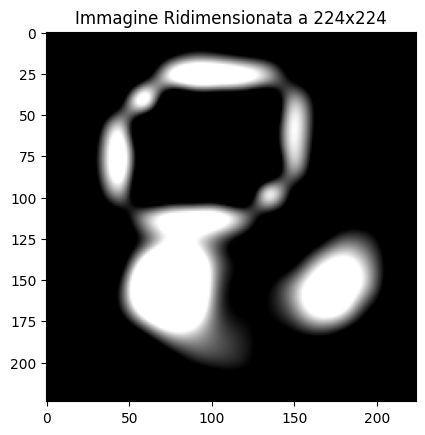

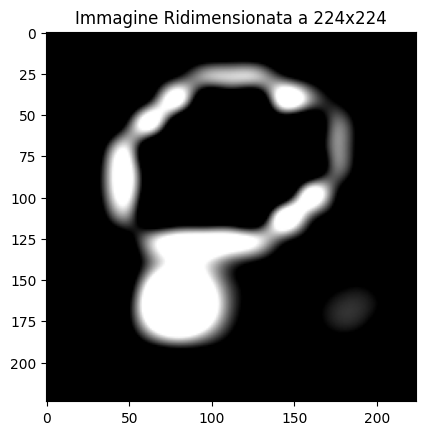

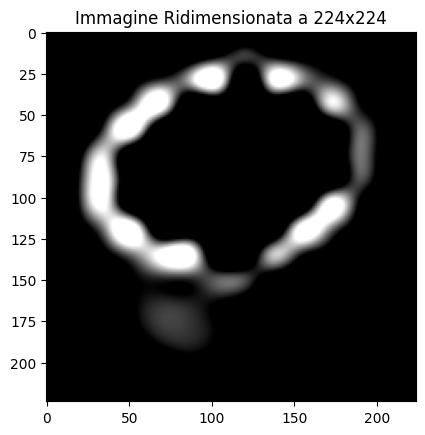

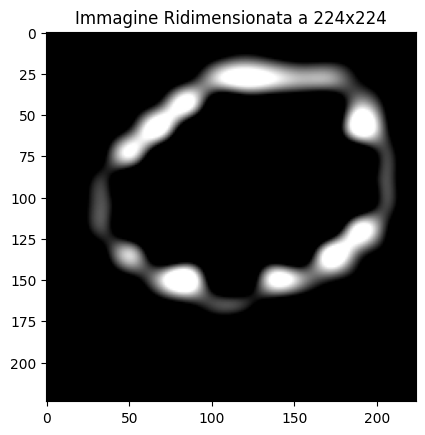

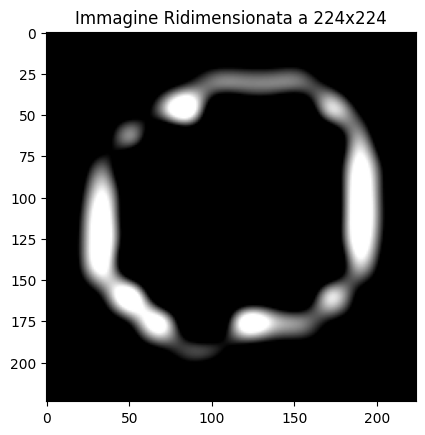

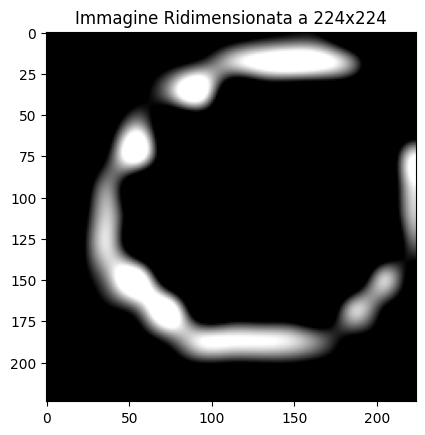

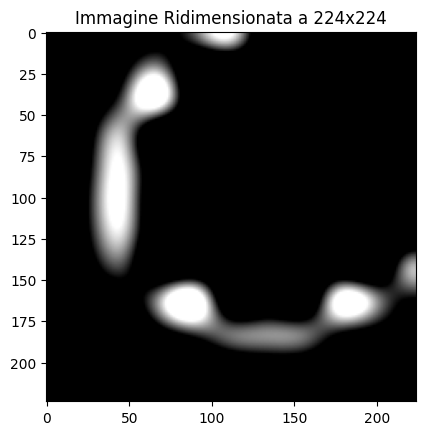

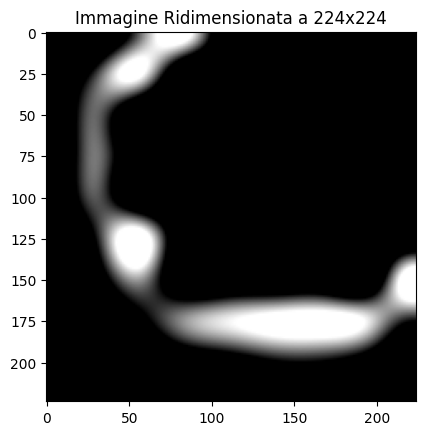

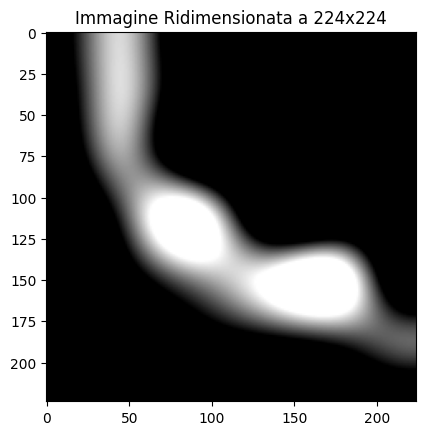

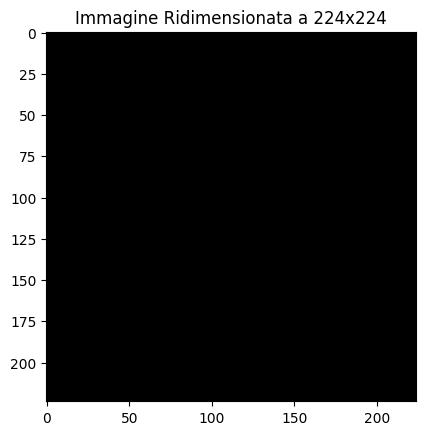

(38, 224, 224, 3)


KeyboardInterrupt: 

In [41]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"


def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def featureextraction(image_array, mask_array, patient_id):
    # Inizializza lista per il batch di slice
    batch_slices = []
    original_slice_indices = []

    # Processa ogni slice singolarmente
    for slice_idx in range(image_array.shape[0]):  # Itera su tutte le slice
        image_slice = image_array[slice_idx]
        mask_slice = mask_array[slice_idx]

        # Se la maschera ha valori diversi da 0, processa la slice
        if np.any(mask_slice):
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)
            
            masked_image = np.where(mask_slice > 0, image_slice, 0)

            cropped_slice = masked_image[ystart:ystop, xstart:xstop]

            zoom_factors = [224 / cropped_slice.shape[0], 224 / cropped_slice.shape[1]]
            resized_slice = zoom(cropped_slice, zoom=zoom_factors, order=3)

            plt.imshow(resized_slice, cmap='gray')
            plt.title("Immagine Ridimensionata a 224x224")
            #plt.show()
            
            x = image.img_to_array(resized_slice)

            x = np.repeat(x, 3, axis=-1) 
            x = preprocess_input(x)

            # Aggiungi la slice al batch
            batch_slices.append(x)
            # Salva l'indice reale della slice per il CSV finale
            original_slice_indices.append(slice_idx)

    print("Indici iniziali e finali: ",original_slice_indices[0], original_slice_indices[-1])
    # Converti tutte le slice in un batch di input per ResNet
    batch_slices = np.array(batch_slices)

    for i in range(len(batch_slices)):
        plt.imshow(batch_slices[i], cmap='gray')
        plt.title("Immagine Ridimensionata a 224x224")
        plt.show()

    print(batch_slices.shape)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        #print(feature_map.shape)
        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        
        ## Global Max Pooling
        #features = np.max(feature_map, -1)
        #features = np.max(features, -1)
        
        ## Global Average Pooling
        features = np.mean(feature_map, axis=-1)
        features = np.mean(features, axis=-1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCEPTION_ALL_SLICES_Imagenet_annerita.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    



### Imagenet Ritagliata

Processing patient: 100
Indici iniziali e finali:  191 228
(38, 224, 224, 3)
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:6 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002715F7ECDC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step
Processing patient: 101
Indici iniziali e finali:  215 256
(42, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 602ms/step
Proces

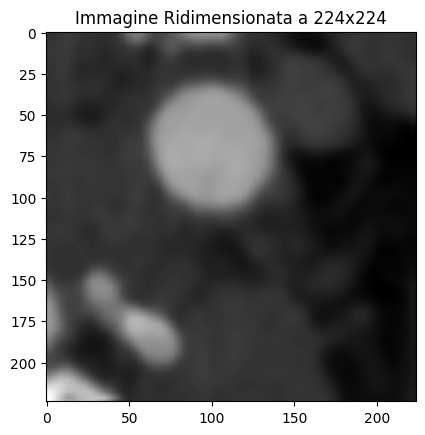

In [13]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

model = VGG19(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"


def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def featureextraction(image_array, mask_array, patient_id):
    # Inizializza lista per il batch di slice
    batch_slices = []
    original_slice_indices = []

    # Processa ogni slice singolarmente
    for slice_idx in range(image_array.shape[0]):  # Itera su tutte le slice
        image_slice = image_array[slice_idx]
        mask_slice = mask_array[slice_idx]

        # Se la maschera ha valori diversi da 0, processa la slice
        if np.any(mask_slice):
            
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)

            # Definisci il centro dell'area della placca
            center_y = (ystart + ystop) // 2
            center_x = (xstart + xstop) // 2

            # Definisci il lato del quadrato attorno alla placca
            half_side = min(center_y, center_x, 30)  # Regola per il contesto desiderato
            roi_image = image_slice[
                max(0, center_y-half_side):min(center_y+half_side, image_slice.shape[0]), 
                max(0, center_x-half_side):min(center_x+half_side, image_slice.shape[1])
            ]
            roi_image = roi_image.astype(np.float32)

            # Ridimensiona l'area estratta a 224x224
            roi_image_resized = resize(roi_image, (224, 224), order=1, anti_aliasing=True)

            x = image.img_to_array(roi_image_resized)
            x = np.repeat(x, 3, axis=-1) 

            # Aggiungi la slice al batch
            batch_slices.append(x)
            # Salva l'indice reale della slice per il CSV finale
            original_slice_indices.append(slice_idx)

    print("Indici iniziali e finali: ",original_slice_indices[0], original_slice_indices[-1])
    # Converti tutte le slice in un batch di input per ResNet
    batch_slices = np.array(batch_slices)

    for i in range(len(batch_slices)):
        plt.imshow(batch_slices[i][:,:,0], cmap='gray')
        plt.title("Immagine Ridimensionata a 224x224")
        #plt.show()

    print(batch_slices.shape)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        
        ## Global Max Pooling
        features = np.max(feature_map, -1)
        features = np.max(features, -1)
        
        ## Global Average Pooling
        #features = np.mean(feature_map, axis=-1)
        #features = np.mean(features, axis=-1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\VGG_ALL_SLICES_Imagenet_ritagliata.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    



### Imagenet Full Image

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"


def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def featureextraction(image_array, mask_array, patient_id):
    # Inizializza lista per il batch di slice
    batch_slices = []
    original_slice_indices = []

    # Processa ogni slice singolarmente
    for slice_idx in range(image_array.shape[0]):  # Itera su tutte le slice
        image_slice = image_array[slice_idx]
        mask_slice = mask_array[slice_idx]

        # Se la maschera ha valori diversi da 0, processa la slice
        if np.any(mask_slice):
            
            # Ridimensiona l'area estratta a 224x224
            roi_image_resized = cv2.resize(image_slice, (224, 224), interpolation=cv2.INTER_LINEAR)
            
            x = image.img_to_array(roi_image_resized)

            x = np.repeat(x, 3, axis=-1) 
            x = preprocess_input(x)

            # Aggiungi la slice al batch
            batch_slices.append(x)
            # Salva l'indice reale della slice per il CSV finale
            original_slice_indices.append(slice_idx)

    print("Indici iniziali e finali: ",original_slice_indices[0], original_slice_indices[-1])
    # Converti tutte le slice in un batch di input per ResNet
    batch_slices = np.array(batch_slices)

    print(batch_slices.shape)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        #print(feature_map.shape)
        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        
        ## Global Max Pooling
        features = np.max(feature_map, -1)
        features = np.max(features, -1)
        
        ## Global Average Pooling
        #features = np.mean(feature_map, axis=-1)
        #features = np.mean(features, axis=-1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\RESNET_ALL_SLICES_Imagenet_annerita.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    



### Nuovi pesi Annerita

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

model = VGG19(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"


def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def featureextraction(image_array, mask_array, patient_id):
    # Inizializza lista per il batch di slice
    batch_slices = []
    original_slice_indices = []

    # Processa ogni slice singolarmente
    for slice_idx in range(image_array.shape[0]):  # Itera su tutte le slice
        image_slice = image_array[slice_idx]
        mask_slice = mask_array[slice_idx]

        # Se la maschera ha valori diversi da 0, processa la slice
        if np.any(mask_slice):
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)
            
            masked_image = np.where(mask_slice > 0, image_slice, 0)

            cropped_slice = masked_image[ystart:ystop, xstart:xstop]

            zoom_factors = [224 / cropped_slice.shape[0], 224 / cropped_slice.shape[1]]
            resized_slice = zoom(cropped_slice, zoom=zoom_factors, order=3)

            plt.imshow(resized_slice, cmap='gray')
            plt.title("Immagine Ridimensionata a 224x224")
            #plt.show()
            
            x = image.img_to_array(resized_slice)

            # Aggiungi la slice al batch
            batch_slices.append(x)

            x = np.repeat(x, 3, axis=-1) 
            # Salva l'indice reale della slice per il CSV finale
            original_slice_indices.append(slice_idx)

    batch_slices = np.array(batch_slices)
    
    global_min = np.min(batch_slices)
    global_max = np.max(batch_slices)

    # Normalizza l'intero batch usando il minimo e massimo globali
    batch_slices = (batch_slices - global_min) / (global_max - global_min)

    print("Indici iniziali e finali: ",original_slice_indices[0], original_slice_indices[-1])

    print(batch_slices.shape)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        #print(feature_map.shape)
        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        
        ## Global Max Pooling
        features = np.max(feature_map, -1)
        features = np.max(features, -1)
        
        ## Global Average Pooling
        #features = np.mean(feature_map, axis=-1)
        #features = np.mean(features, axis=-1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\VGG_ALL_SLICES_Imagenet_annerita.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    



### Nuovi Pesi ritagliata

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

model = VGG19(weights='imagenet', include_top=False)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"


def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def featureextraction(image_array, mask_array, patient_id):
    # Inizializza lista per il batch di slice
    batch_slices = []
    original_slice_indices = []

    # Processa ogni slice singolarmente
    for slice_idx in range(image_array.shape[0]):  # Itera su tutte le slice
        image_slice = image_array[slice_idx]
        mask_slice = mask_array[slice_idx]

        # Se la maschera ha valori diversi da 0, processa la slice
        if np.any(mask_slice):
            (ystart, xstart), (ystop, xstop) = maskcroppingbox(mask_slice)

            # Definisci il centro dell'area della placca
            center_y = (ystart + ystop) // 2
            center_x = (xstart + xstop) // 2

            # Definisci il lato del quadrato attorno alla placca
            half_side = min(center_y, center_x, 30)  # Regola per il contesto desiderato

            image_slice_normalized = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice)) 
            roi_image = image_slice_normalized[
                max(0, center_y-half_side):min(center_y+half_side, image_slice.shape[0]), 
                max(0, center_x-half_side):min(center_x+half_side, image_slice.shape[1])
            ]
            
            # Ridimensiona l'area estratta a 224x224
            roi_image_resized = resize(roi_image, (224, 224), order=1, anti_aliasing=True)
            
            x = image.img_to_array(roi_image_resized)

            # Aggiungi la slice al batch
            batch_slices.append(x)

            x = np.repeat(x, 3, axis=-1) 
            # Salva l'indice reale della slice per il CSV finale
            original_slice_indices.append(slice_idx)

    batch_slices = np.array(batch_slices)

    print("Indici iniziali e finali: ",original_slice_indices[0], original_slice_indices[-1])

    print(batch_slices.shape)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        #print(feature_map.shape)
        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        
        ## Global Max Pooling
        features = np.max(feature_map, -1)
        features = np.max(features, -1)
        
        ## Global Average Pooling
        #features = np.mean(feature_map, axis=-1)
        #features = np.mean(features, axis=-1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\VGG_ALL_SLICES_Imagenet_annerita.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    



### Nuovi Pesi full image

Processing patient: 100
Indici iniziali e finali:  191 228
(38, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
Processing patient: 101
Indici iniziali e finali:  215 256
(42, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step
Processing patient: 102
Indici iniziali e finali:  192 245
(54, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Processing patient: 103
Indici iniziali e finali:  137 182
(46, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step
Processing patient: 104
Indici iniziali e finali:  207 251
(45, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 989ms/step
Processing patient: 105
Indici iniziali e finali:  165 202
(38, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step
Processing patient: 106
Indici iniziali e finali:  252 281
(30, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processing patient: 107
Indici iniziali e finali:  185 228
(44, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 762ms/step
Processing patient: 108
Indici iniziali e finali:  195 221
(27, 224, 224, 3)
1/1 

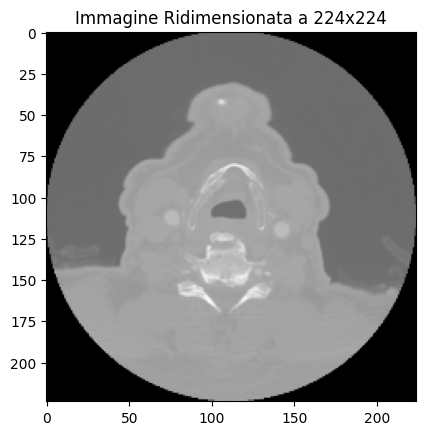

In [19]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

model_path = r"C:\Users\bsbar\Desktop\PreTrained_Models\RadImageNet-IRV2_notop.h5"
model = load_model(model_path)

pathdicom = "\\Users\\bsbar\\Desktop\\pazienti_nrrd"
pathroi = "\\Users\\bsbar\\Desktop\\Tesi\\ROI"


def maskcroppingbox(mask_slice):
    non_zero_coords = np.argwhere(mask_slice)
    (ystart, xstart), (ystop, xstop) = non_zero_coords.min(axis=0), non_zero_coords.max(axis=0) + 1
    return (ystart, xstart), (ystop, xstop)

def featureextraction(image_array, mask_array, patient_id):
    # Inizializza lista per il batch di slice
    batch_slices = []
    original_slice_indices = []

    # Processa ogni slice singolarmente
    for slice_idx in range(image_array.shape[0]):  # Itera su tutte le slice
        image_slice = image_array[slice_idx]
        mask_slice = mask_array[slice_idx]

        # Se la maschera ha valori diversi da 0, processa la slice
        if np.any(mask_slice):
            
            image_slice = image_slice.astype(np.float32)
            roi_image_resized = x = cv2.resize(image_slice, (224, 224))
            
            x = image.img_to_array(roi_image_resized)

            # Aggiungi la slice al batch

            min_val = np.min(x)
            max_val = np.max(x)

            # Normalizza i valori tra 0 e 1 usando min-max normalization
            x = (x - min_val) / (max_val - min_val)

            x = np.repeat(x, 3, axis=-1) 


            batch_slices.append(x) 
            # Salva l'indice reale della slice per il CSV finale
            original_slice_indices.append(slice_idx)

    batch_slices = np.array(batch_slices)
    
    plt.imshow(batch_slices[0][:,:,0], cmap='gray')
    plt.title("Immagine Ridimensionata a 224x224")
    #plt.show()

    print("Indici iniziali e finali: ",original_slice_indices[0], original_slice_indices[-1])

    print(batch_slices.shape)

    # Estrazione feature map per tutto il batch
    base_model_pool_features = model.predict(batch_slices)

    # Inizializza lista per salvare tutte le features
    all_features = []

    # Usa solo le slice corrispondenti agli indici originali
    for i in range(base_model_pool_features.shape[0]):
        feature_map = base_model_pool_features[i]

        #print(feature_map.shape)
        # Trasposizione e riduzione delle features
        feature_map = feature_map.transpose((2, 1, 0))
        
        ## Global Max Pooling
        #features = np.max(feature_map, -1)
        #features = np.max(features, -1)
        
        ## Global Average Pooling
        features = np.mean(feature_map, axis=-1)
        features = np.mean(features, axis=-1)

        # Associa l'indice reale della slice (non sequenziale) dal volume originale
        feature_entry = {'Patient': patient_id, 'Slice': original_slice_indices[i]}  # Usa l'indice reale della slice
        for ind_, f_ in enumerate(features):
            feature_entry[f'Feature_{ind_}'] = f_

        all_features.append(feature_entry)

    return all_features


all_feature_dicts = []

for s in os.listdir(pathdicom):
    print(f"Processing patient: {s}")
    filename = os.path.join(pathdicom, s)

    for t in os.listdir(filename):
        pathdicomnew = os.path.join(pathdicom, s, t)
        readdatadicom, header = nrrd.read(pathdicomnew, index_order='C')

    pathroinew = os.path.join(pathroi, s)
    for g in os.listdir(pathroinew):
        troi = os.path.join(pathroi, s, g)
        readdatanrrd, header2 = nrrd.read(troi, index_order='C')

    # Estrai tutte le features e gli indici delle slice in 3D
    patient_features = featureextraction(readdatadicom, readdatanrrd, patient_id=s)

    # Aggiungi le feature di tutte le slice per questo paziente
    all_feature_dicts.extend(patient_features)

# Crea il DataFrame con le feature di tutte le slice e pazienti
dataframe = pd.DataFrame(all_feature_dicts)

# Salva il DataFrame in un file CSV
dataframe.to_csv('C:\\Users\\bsbar\\Desktop\\INCRES_ALL_SLICES_NuoviPesi_FullImage.csv', index=False)

print("CSV con gli indici 3D salvato con successo.")
    

